<a href="https://colab.research.google.com/github/Midhilesh4890/Text-Classification-With-BERT/blob/main/Data_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

     |████████████████████████████████| 2.1MB 5.5MB/s 
     |████████████████████████████████| 901kB 19.4MB/s 
     |████████████████████████████████| 3.3MB 16.8MB/s 


In [18]:
import transformers 
import torch
import copy
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from matplotlib import rc
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch import nn,optim
from torch.utils import data

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(style='whitegrid',palette='muted',font_scale=1.2)

HAPPY_COLORS_PALETTE = ['#01BEFE','#FFDD00','#FF7D00','#FF006D','#ADFF02','#8F00FF']

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 8,6

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [19]:
df = pd.read_csv('/content/drive/MyDrive/BERT/reviews.csv')
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,SortOrder,appId
0,gp:AOqpTOFXo3npLcLsjHbEKXc3Y3L2UapFATad-0V02Yh...,Alan Ball,https://play-lh.googleusercontent.com/a-/AOh14...,the organiser is really helpful but I hate tha...,1,15,5.13.1.4,2021-04-11 22:06:14,We're sorry to hear you're experiencing issues...,2021-04-12 08:01:28,most_relevant,com.anydo
1,gp:AOqpTOHKyfF4SoapkJCri8CxpvmiW7L-_ejHVjc24w4...,Marilia Gomes de Souza,https://play-lh.googleusercontent.com/a-/AOh14...,continuously problem with sync on two accounts...,1,1,5.13.1.4,2021-04-11 15:06:43,We are not aware of any issues with sharing li...,2021-04-12 07:41:47,most_relevant,com.anydo
2,gp:AOqpTOGfvRJtomIZ_XCP9Qsn1bFXc2rX1kvtX3_OtFY...,Ron Alon,https://play-lh.googleusercontent.com/a-/AOh14...,"Horrible app, it was ok for a while, but now i...",1,0,5.13.2.3,2021-04-22 07:32:23,Please note that Any.do syncs often but not in...,2021-04-22 08:56:08,most_relevant,com.anydo
3,gp:AOqpTOFiXIalPjizMDKUvRJxPswDBz-I_3tuFvTEHUN...,Aadil Feroze,https://play-lh.googleusercontent.com/-MsuPkz4...,"Was such an awesome app, after the last update...",1,0,5.13.2.3,2021-04-19 20:10:40,We're sorry to hear you're experiencing issues...,2021-04-20 08:26:15,most_relevant,com.anydo
4,gp:AOqpTOFLOAijC9jUThwqjTGbCiV374goO5k4TgZepG1...,Rodrigo Amorim,https://play-lh.googleusercontent.com/-iAZWiAj...,$$$ Im being charged a full year up front and ...,1,11,5.12.1.1,2021-04-07 21:18:29,A payment can only be made upon the user's aut...,2021-04-08 09:46:04,most_relevant,com.anydo


In [20]:
df.shape

(16506, 12)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16506 entries, 0 to 16505
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              16506 non-null  object
 1   userName              16506 non-null  object
 2   userImage             16506 non-null  object
 3   content               16505 non-null  object
 4   score                 16506 non-null  int64 
 5   thumbsUpCount         16506 non-null  int64 
 6   reviewCreatedVersion  14044 non-null  object
 7   at                    16506 non-null  object
 8   replyContent          8334 non-null   object
 9   repliedAt             8334 non-null   object
 10  SortOrder             16506 non-null  object
 11  appId                 16506 non-null  object
dtypes: int64(2), object(10)
memory usage: 1.5+ MB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'review score')

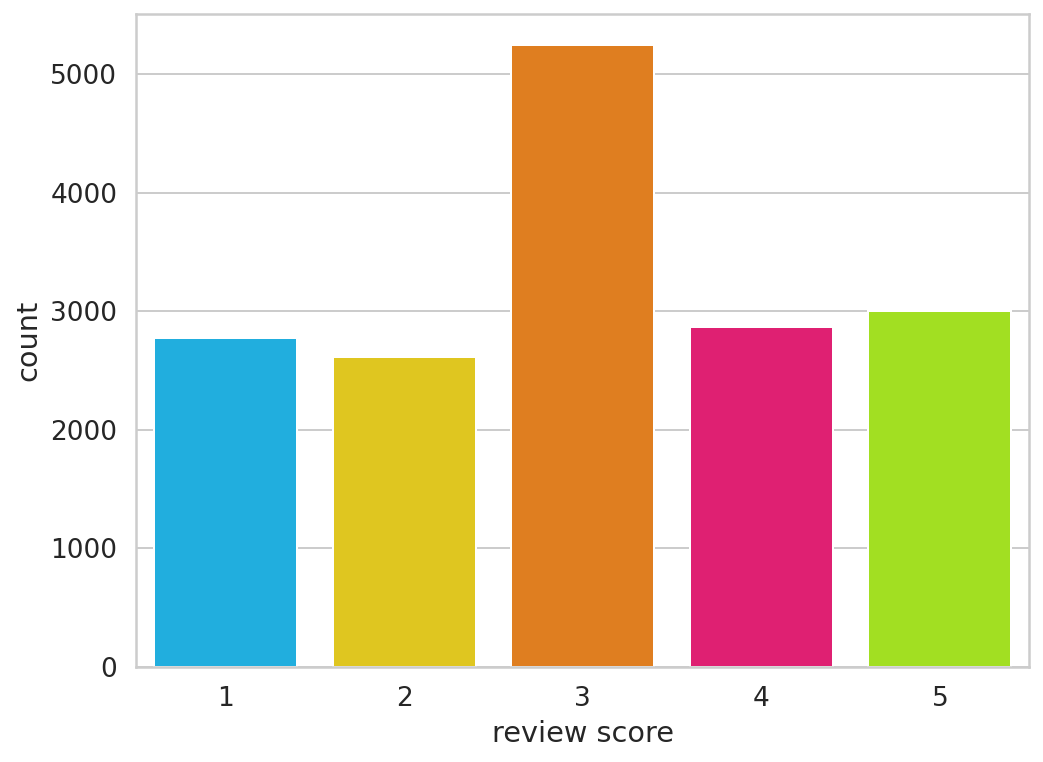

In [22]:
sns.countplot(df.score)
plt.xlabel('review score')

In [23]:
def to_sentiment(rating):
    rating = int(rating)
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2
        

In [24]:
df['sentiment'] = df.score.apply(to_sentiment)

In [25]:
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,SortOrder,appId,sentiment
0,gp:AOqpTOFXo3npLcLsjHbEKXc3Y3L2UapFATad-0V02Yh...,Alan Ball,https://play-lh.googleusercontent.com/a-/AOh14...,the organiser is really helpful but I hate tha...,1,15,5.13.1.4,2021-04-11 22:06:14,We're sorry to hear you're experiencing issues...,2021-04-12 08:01:28,most_relevant,com.anydo,0
1,gp:AOqpTOHKyfF4SoapkJCri8CxpvmiW7L-_ejHVjc24w4...,Marilia Gomes de Souza,https://play-lh.googleusercontent.com/a-/AOh14...,continuously problem with sync on two accounts...,1,1,5.13.1.4,2021-04-11 15:06:43,We are not aware of any issues with sharing li...,2021-04-12 07:41:47,most_relevant,com.anydo,0
2,gp:AOqpTOGfvRJtomIZ_XCP9Qsn1bFXc2rX1kvtX3_OtFY...,Ron Alon,https://play-lh.googleusercontent.com/a-/AOh14...,"Horrible app, it was ok for a while, but now i...",1,0,5.13.2.3,2021-04-22 07:32:23,Please note that Any.do syncs often but not in...,2021-04-22 08:56:08,most_relevant,com.anydo,0
3,gp:AOqpTOFiXIalPjizMDKUvRJxPswDBz-I_3tuFvTEHUN...,Aadil Feroze,https://play-lh.googleusercontent.com/-MsuPkz4...,"Was such an awesome app, after the last update...",1,0,5.13.2.3,2021-04-19 20:10:40,We're sorry to hear you're experiencing issues...,2021-04-20 08:26:15,most_relevant,com.anydo,0
4,gp:AOqpTOFLOAijC9jUThwqjTGbCiV374goO5k4TgZepG1...,Rodrigo Amorim,https://play-lh.googleusercontent.com/-iAZWiAj...,$$$ Im being charged a full year up front and ...,1,11,5.12.1.1,2021-04-07 21:18:29,A payment can only be made upon the user's aut...,2021-04-08 09:46:04,most_relevant,com.anydo,0


In [26]:
class_names = ['negative','positive','neutral']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, 'negative'), Text(0, 0, 'positive'), Text(0, 0, 'neutral')]

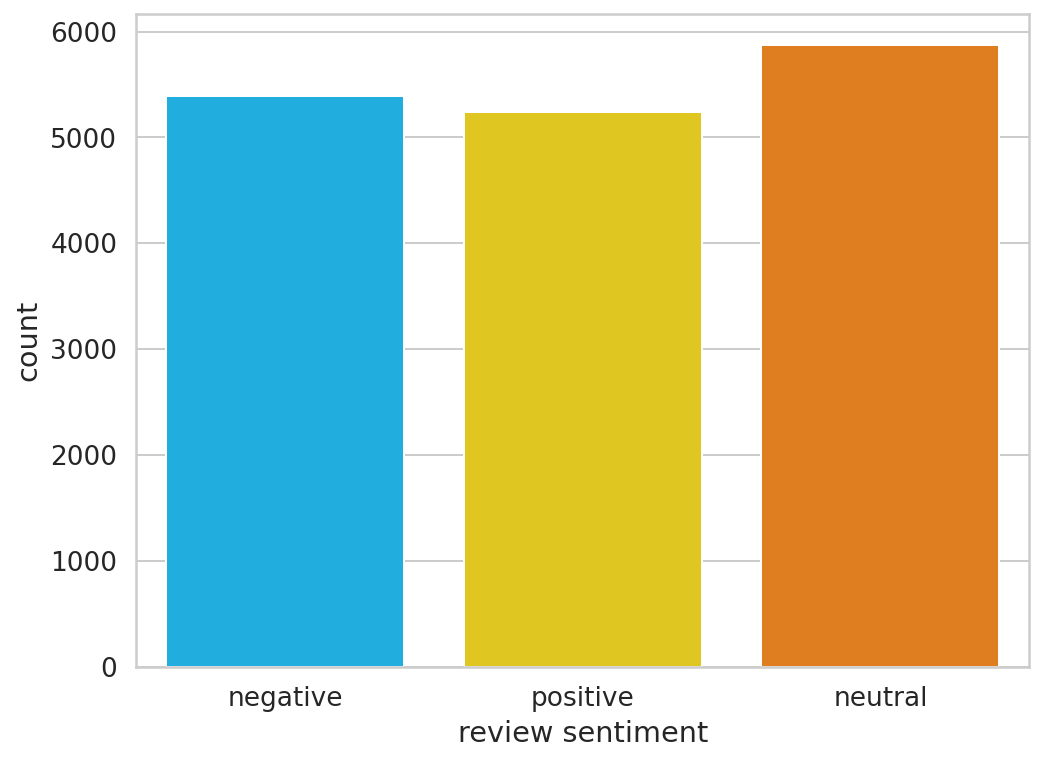

In [27]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names)

## Data Preprocessing

In [28]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

In [35]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

In [36]:
tokens = tokenizer.tokenize(sample_txt)

In [37]:
print(tokens)

['when', 'was', 'i', 'last', 'outside', '?', 'i', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']


In [38]:
token_ids = tokenizer.convert_tokens_to_ids(tokens)

In [39]:
print(token_ids)

[2043, 2001, 1045, 2197, 2648, 1029, 1045, 2572, 5881, 2012, 2188, 2005, 1016, 3134, 1012]


## Special Tokens

In [40]:
tokenizer.sep_token,tokenizer.sep_token_id

('[SEP]', 102)

In [41]:
tokenizer.cls_token,tokenizer.cls_token_id

('[CLS]', 101)

In [42]:
tokenizer.pad_token,tokenizer.pad_token_id

('[PAD]', 0)

In [43]:
tokenizer.unk_token,tokenizer.unk_token_id

('[UNK]', 100)

In [48]:
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length=32,
    add_special_tokens = True,
    pad_to_max_length = True,
    return_attention_mask = True,
    return_token_type_ids = False,
    return_tensors = 'pt'
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [53]:
encoding['input_ids']

tensor([[ 101, 2043, 2001, 1045, 2197, 2648, 1029, 1045, 2572, 5881, 2012, 2188,
         2005, 1016, 3134, 1012,  102,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])

In [54]:
encoding['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

## Choosing Sequence Lengths

In [59]:
token_lens = []
for txt in df.content:
    tokens = tokenizer.encode(str(txt),max_length=512)
    token_lens.append(len(tokens))

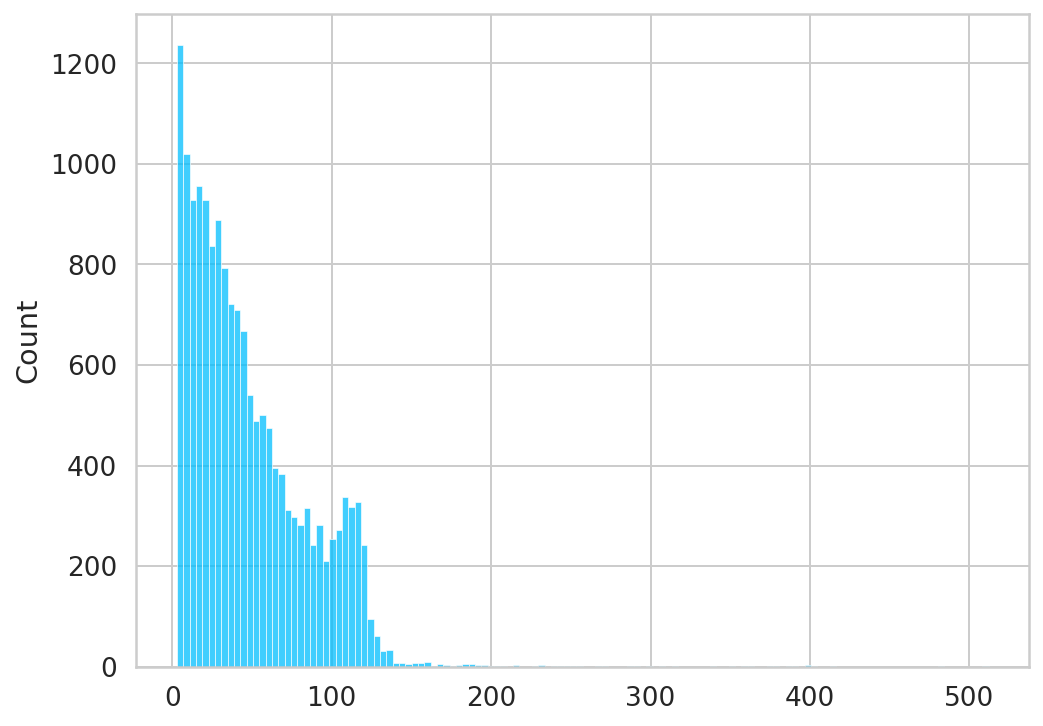

In [60]:
sns.histplot(token_lens)

## Create Dataset

In [61]:
class GPReviewDataset(data.Dataset):
    def __init__(self,review,target,tokenizer,max_len):
        self.review = review
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.review)

    def __getitem__(self, item):
        review = str(self.review[item])
        encoding = tokenizer.encode_plus(
                    review,
                    max_length=self.max_len,
                    add_special_tokens = True,
                    pad_to_max_length = True,
                    return_attention_mask = True,
                    return_token_type_ids = False,
                    return_tensors = 'pt'
                )
        
        return {
            'input_ids':encoding['input_ids'],
            'attention_mask':encoding['attention_mask'],
            'targets': torch.tensor(self.target[item],dtype=torch.long)
        }

    

In [62]:
MAX_LEN = 128
BATCH_SIZE = 8
EPOCHS = 20

In [63]:
df_train,df_test = train_test_split(df,test_size=0.2,random_state=RANDOM_SEED)
df_val,df_test = train_test_split(df_test,test_size=0.5,random_state=RANDOM_SEED)

In [64]:
df_train.shape,df_val.shape,df_test.shape

((13204, 13), (1651, 13), (1651, 13))

In [66]:
def create_data_loader(df,tokenizer,max_len,batch_size):
    ds = GPReviewDataset(
        review = df.content.to_numpy(),
        target = df.sentiment.to_numpy(),
        tokenizer = tokenizer,
        max_len = max_len
    )

    return data.DataLoader(
        ds,
        batch_size = batch_size,
        num_workers = 4
    )

In [67]:
train_data_loader = create_data_loader(df_train,tokenizer,MAX_LEN,BATCH_SIZE)
val_data_loader = create_data_loader(df_val,tokenizer,MAX_LEN,BATCH_SIZE)
test_data_loader = create_data_loader(df_test,tokenizer,MAX_LEN,BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [68]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

dict_keys(['input_ids', 'attention_mask', 'targets'])

In [71]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([8, 1, 128])
torch.Size([8, 1, 128])
torch.Size([8])
